In [24]:
import sys
import os
import matplotlib


import warnings
warnings.filterwarnings('ignore') #dette er bare for å skjule skrift warnings mtp. bruk av skrift type osv


matplotlib.rcParams['font.family'] = 'DejaVu Sans'


notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(os.path.join(project_root, 'src'))


from data_visualizations.dataframes import build_dataframe_from_json, build_dataframe_from_db
from data_visualizations.nilu import nilu_plotly, get_cleaned_data_path


json_df = build_dataframe_from_json('cleaned_data_nilu.json')
db_df = build_dataframe_from_db('frost.db', 'weather_data')
nilu_plotly = nilu_plotly(get_cleaned_data_path('cleaned_data_nilu.json'))

# 📊 Data visualisering og analyse

Denne notebooken bygger videre på data vi har hentet og renset fra både **Frost** og **NILU**. Vi skal nå starte analysen og visualiseringen av dataen og forsøke å trekke ut meningsfull innsikt. Vi vil bruke visuelle fremstillinger for å forstå variasjoner, sammenhenger og trender i miljødataen. Først skal vi se luftkvaliteten i Trondheim før vi går videre på været.

Målet er å identifisere mønstre som er interessante i seg selv (f.eks. hvordan luftkvalitet varierer gjennom året), men også å gi et godt kunnskaps og sammenlignings-grunnlag for å forstå den prediktive analysen i neste steg av prosjektet.

### 🌫️ - Luftkvaliteten i Trondheim
Først skal vi få oversikt over statistiske verdier som gjennomsnitt, median og standaravvik over ulike luftkvalitets indikatorer, som gir oss en rask oversikt over dataens fordeling, variasjon og typiske verdier. Dette hjelper oss med å forstå dataen og identifisere eventuelle avvik eller mønstre.

**DataFrame over luftkvalitet**

In [25]:
print(json_df)

     dateTime      NO2     PM10    PM2.5  generated_NO2  generated_PM10  generated_PM2.5
0  2010-01-01  25.7208  39.1000  12.8957          False           False             True
1  2010-01-02  26.8000  30.8542  12.8248          False           False             True
2  2010-01-03  13.3208   9.7208   8.5542          False           False            False
3  2010-01-04  47.7167  23.6708  20.7542          False           False            False
4  2010-01-05  47.4542  25.8250  24.9000          False           False            False
5  2010-01-06  59.3042  39.9417  18.6051          False           False             True


Videre ønsker vi å se på datasettet i sin helhet. Til dette har vi brukt plotly for å lage en interaktiv graf, hvor man selv enkelt kan filtrere ut enkelte verdier, skalere tidslinjen og lese av nøyaktige verdier for hver observasjon.

In [26]:
# Hente inn ploty over NILU
nilu_plotly.show()

### 🌦️ - Været i Trondheim
Nå går vi fra luftkvalitet til værdata og skal undersøke været i Trondheim de siste årene. Som med luftkvaliteten starter vi med å analysere statistikken for å få en god oversikt over dataene. 

In [27]:
# Hente inn dataframe for Frost
print(db_df)

  referenceTime  mean_air_temperature  mean_wind_speed  total_precipitation  generated_mean_air_temperature  generated_mean_wind_speed  generated_total_precipitation
0    2010-01-01                 -10.0              1.6                  2.1                               0                          0                              0
1    2010-01-02                 -13.5              2.6                  0.1                               0                          0                              0
2    2010-01-03                  -2.3              3.0                  1.1                               0                          0                              0
3    2010-01-04                  -4.7              2.8                  7.9                               0                          0                              0
4    2010-01-05                 -15.8              2.7                  0.4                               0                          0                              0
5   

### Temperaturvariasjon per måned

Først ser vi på hvordan gjennomsnittstemperaturen varierer gjennom året. Boxplot viser median, kvartiler og eventuelle utliggere, noe som gir en god innsikt i variasjonen og stabiliteten av temperaturene måned for måned.


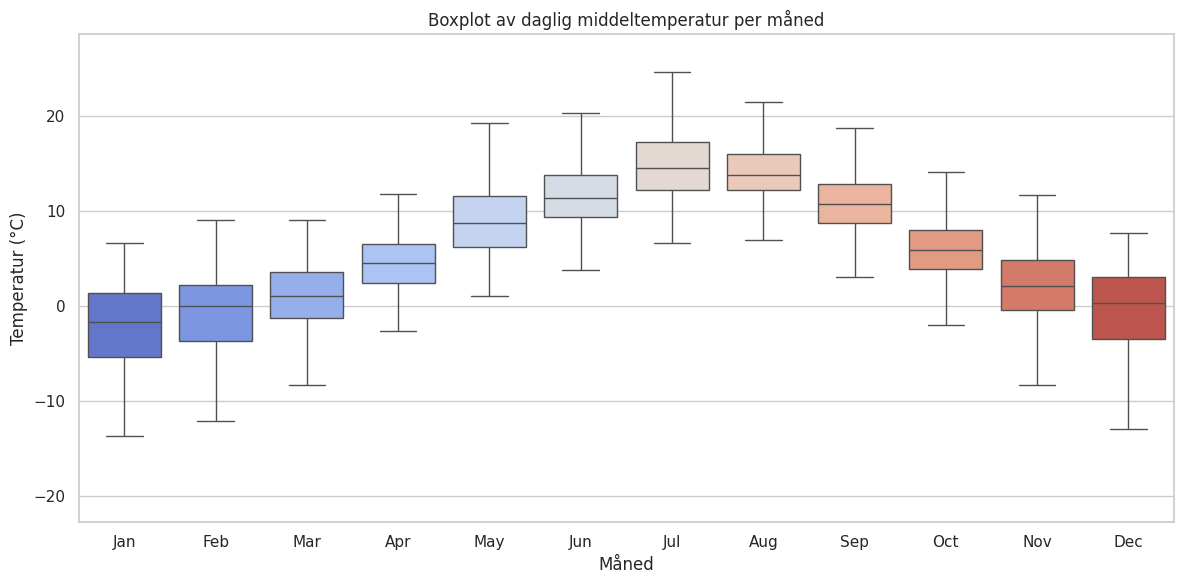

In [28]:
from data_visualizations.frost_visualization.temperature_boxplot import vis_temp_per_måned
vis_temp_per_måned("../data/clean/frost.db")

### Nedbør per sesong

Neste visualisering viser hvordan nedbør varierer gjennom ulike sesonger. Dette gir et klart bilde av sesongmessige trender og hjelper å forstå ekstremvær som potensielt kan oppstå.


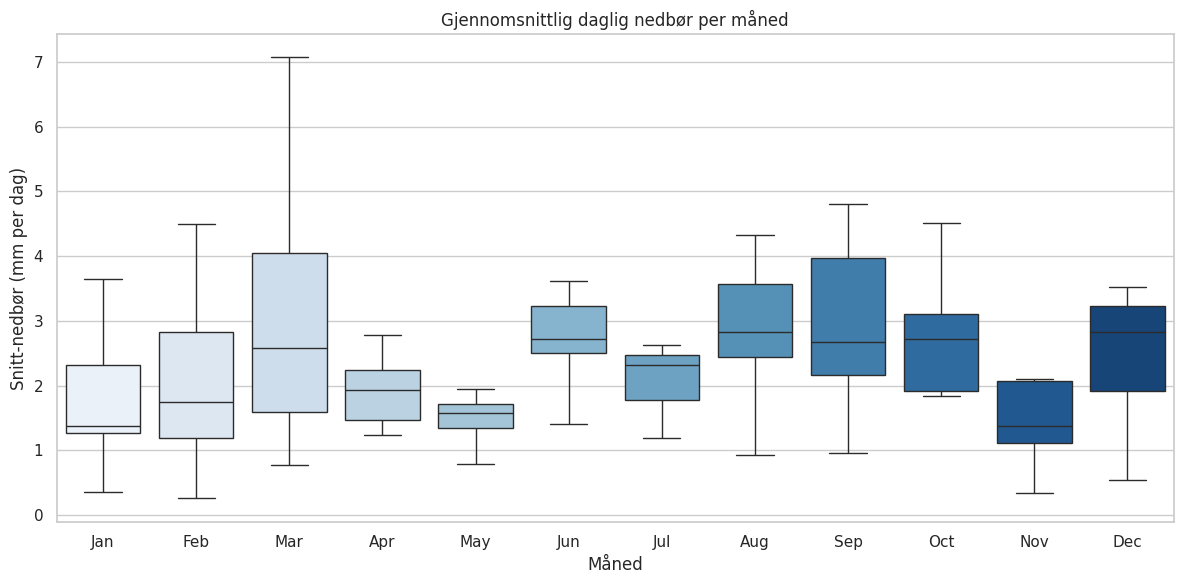

In [29]:
from data_visualizations.frost_visualization.precipitation_boxplot import vis_nedbør_per_måned
vis_nedbør_per_måned("../data/clean/frost.db")

### NO₂-nivå per måned

Videre ser vi på variasjonen av NO₂-nivået per måned. Denne visualiseringen er viktig for å avdekke måneder med økt forurensning, noe som kan kobles til faktorer som økt biltrafikk eller sesongmessige forhold.


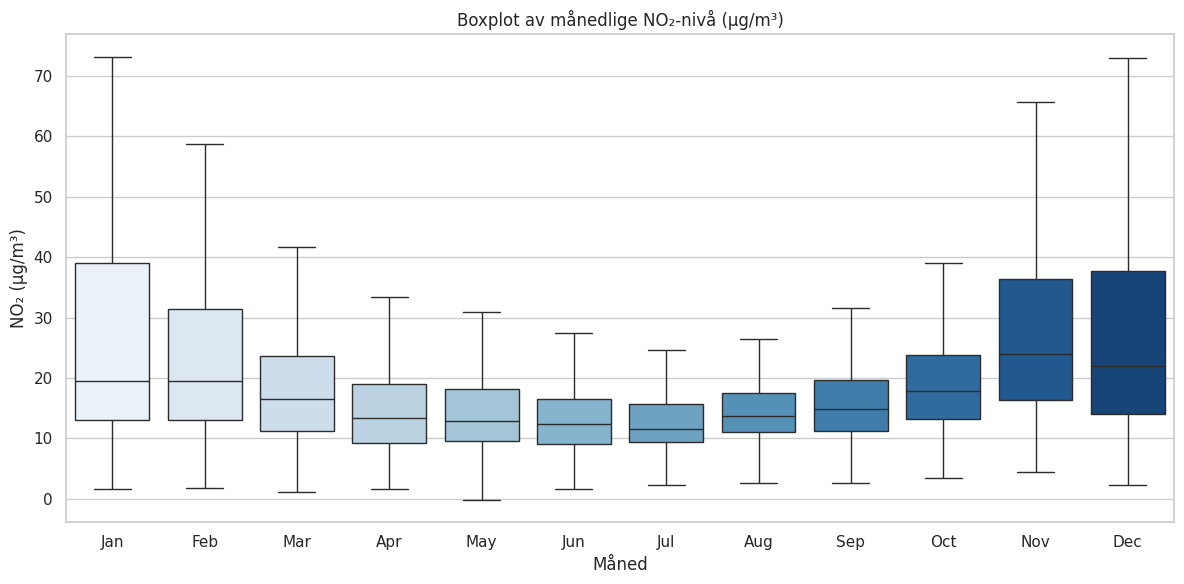

In [30]:
from data_visualizations.nilu_visualization.no2_boxplot_by_month import vis_no2_per_måned
vis_no2_per_måned('../data/clean/cleaned_data_nilu.json')

### PM10-nivå per sesong

Her analyseres PM10-verdiene fordelt på sesonger. Dette gir informasjon om hvilken tid på året det er mest svevestøv, noe som kan være viktig for helsemessige og miljømessige vurderinger.


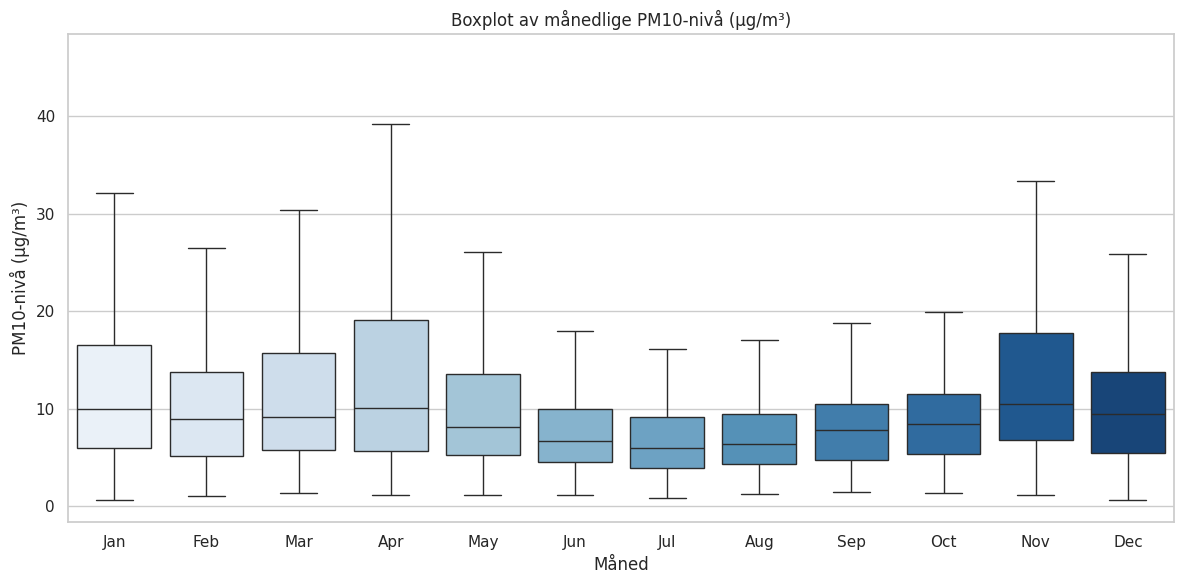

In [31]:
from data_visualizations.nilu_visualization.pm10_boxplot_by_month import vis_pm10_per_måned
vis_pm10_per_måned(('../data/clean/cleaned_data_nilu.json'))

### Daglige værtrender gjennom året

Denne grafen viser daglige endringer i temperatur og nedbør over tid, og tydeliggjør generelle værtrender samt hvordan disse trendene endrer seg gjennom året.


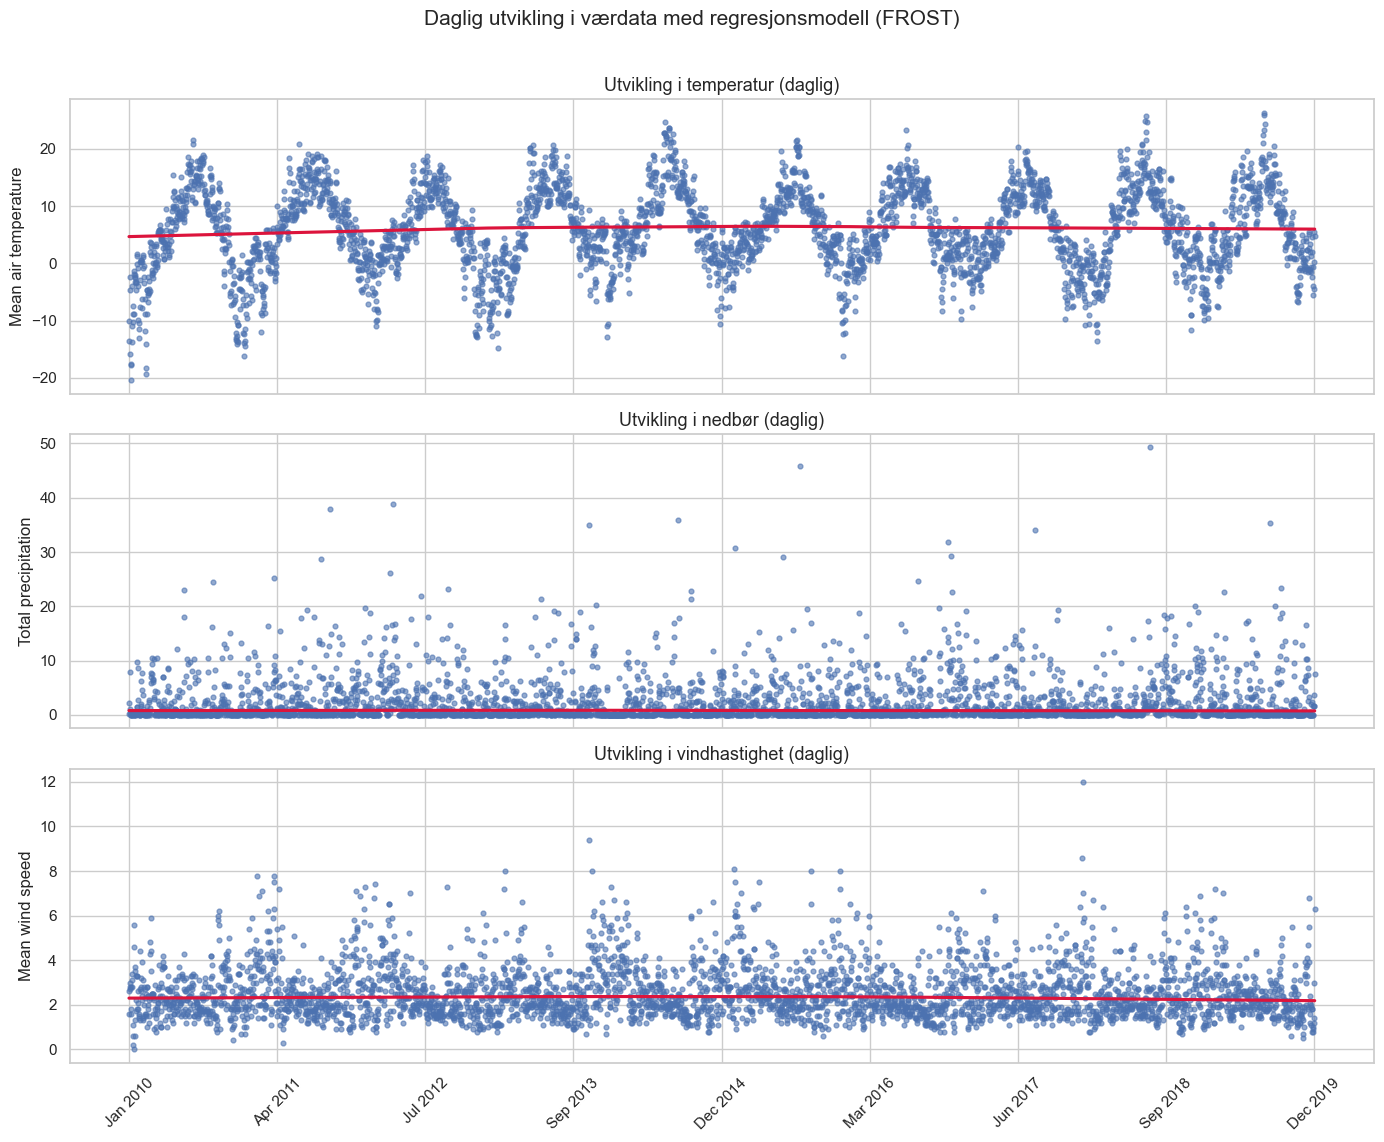

In [32]:
from data_visualizations.frost_visualization.daily_weather_trend_regression import plot_weather_components
plot_weather_components("../data/clean/frost.db")

### Daglige luftforurensningstrender gjennom året

Her viser vi trender i NO₂, PM10 og PM2.5. Disse tidsseriene gir innsikt i hvordan luftkvaliteten varierer dag for dag, og hjelper å forstå underliggende mønstre i luftforurensning.


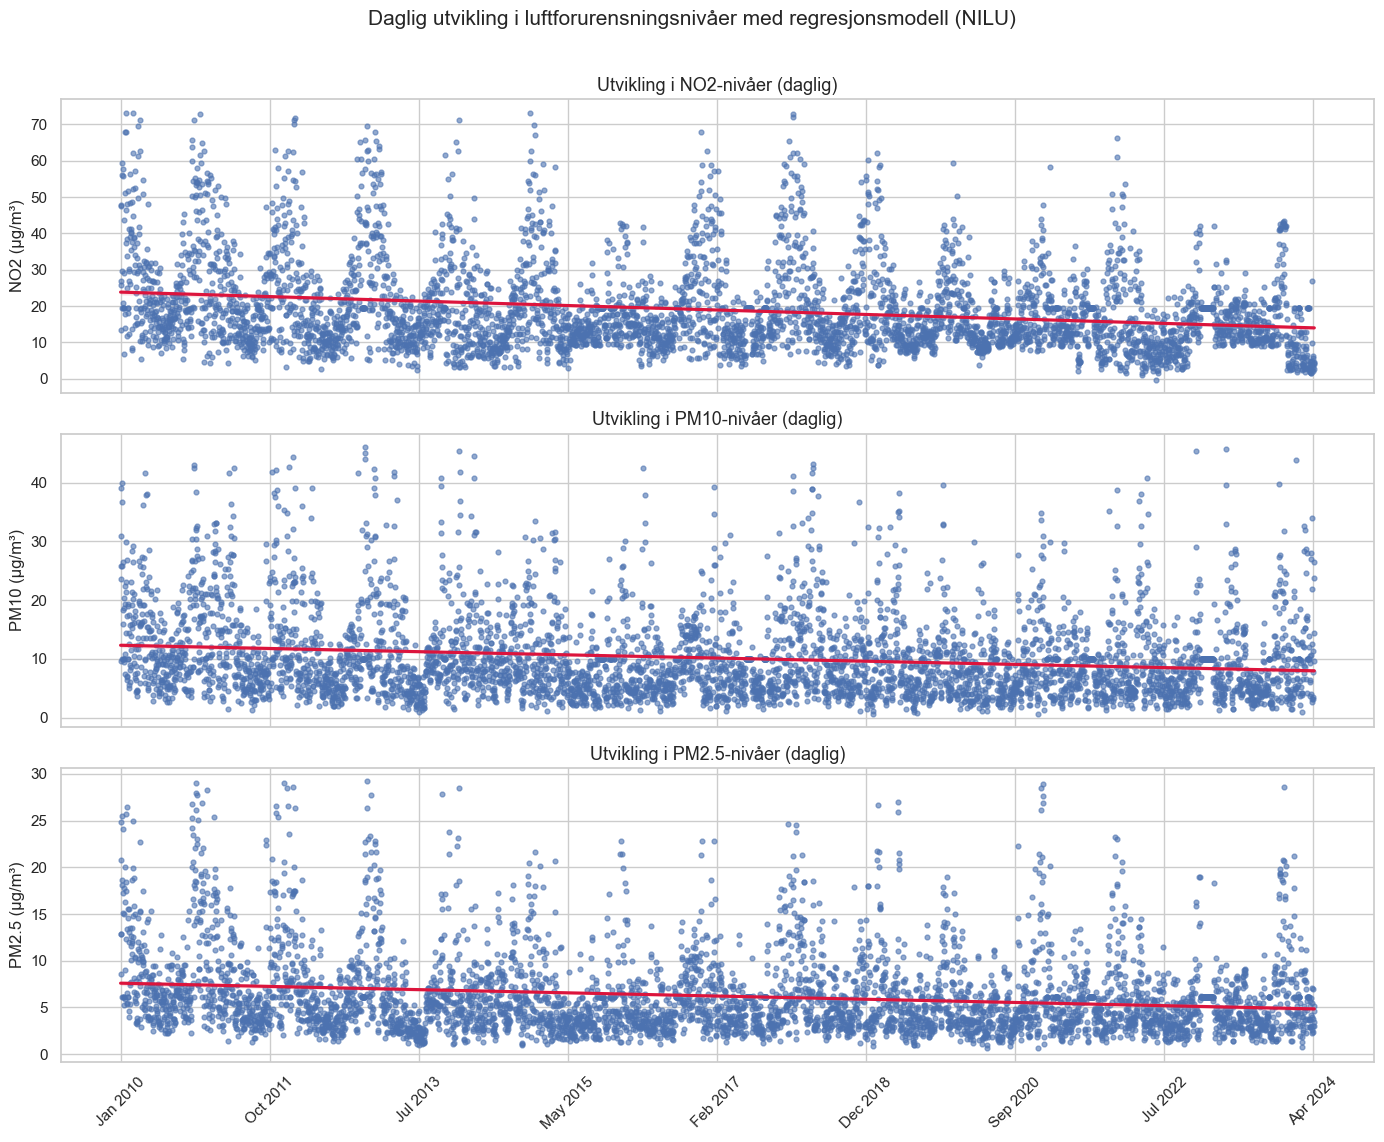

In [33]:
from data_visualizations.nilu_visualization.daily_pollution_trend_regression import vis_luftkvalitet_regresjon_nilu
vis_luftkvalitet_regresjon_nilu("../data/clean/cleaned_data_nilu.json")

### Interaktiv visualisering av værdata

Interaktive grafer med Plotly lar oss utforske værdata dynamisk. Brukeren kan velge spesifikke perioder og variabler, og dermed utforske datasettet dypere enn med statiske visualiseringer.


In [34]:
from data_visualizations.nilu_visualization.nilu_interactive_visualization import plot_seasonal_air_quality
plot_seasonal_air_quality("../data/clean/cleaned_data_nilu.json")

### Interaktiv visualisering av luftkvalitetsdata

På samme måte gir denne interaktive visualiseringen en mer engasjerende måte å forstå luftkvalitetsdataene på. Dynamiske visualiseringer gjør komplekse data enklere å forstå og utforske for sluttbrukere.


In [35]:
from data_visualizations.frost_visualization.frost_interactive_visualization import plot_seasonal_weather_from_sqlite
plot_seasonal_weather_from_sqlite("../data/clean/frost.db")

## Del 5: Statistisk analyse – Korrelasjoner og sammenhenger

I denne delen analyserer vi mer dyptgående statistiske sammenhenger mellom ulike miljøvariabler ved hjelp av korrelasjonsmatriser og scatterplots med regresjonslinjer.  
Målet er å finne og tolke signifikante sammenhenger mellom variablene som ble visualisert tidligere, og å forstå hvordan endringer i én variabel kan påvirke en annen.


### Korrelasjonsmatrise for luftkvalitetsdata (NILU)

Vi starter med en korrelasjonsmatrise som viser sammenhenger mellom NO₂, PM10 og PM2.5. Sterke korrelasjoner kan indikere felles kilder eller påvirkningsfaktorer.


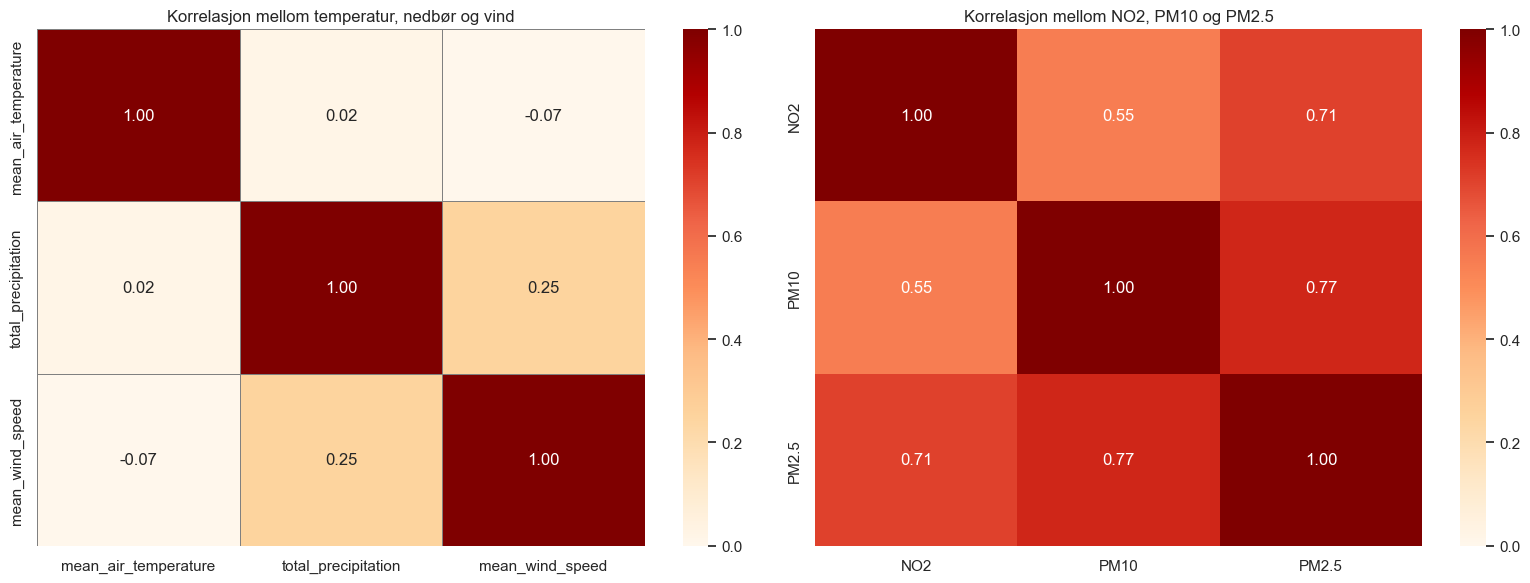

In [22]:
from data_visualizations.frost_vs_nilu_visualization.correlation import vis_korrelasjoner_sammen
vis_korrelasjoner_sammen("../data/analyses_results/frost_correlation_matrix.csv",
                        "../data/analyses_results/nilu_correlation_matrix.csv")


### Sammenheng mellom temperatur og NO₂-nivåer

Denne grafen undersøker sammenhengen mellom temperatur og nivåene av NO₂. Regresjonslinjen viser en tydelig trend som hjelper oss å forstå hvordan luftkvaliteten potensielt påvirkes av temperaturendringer.


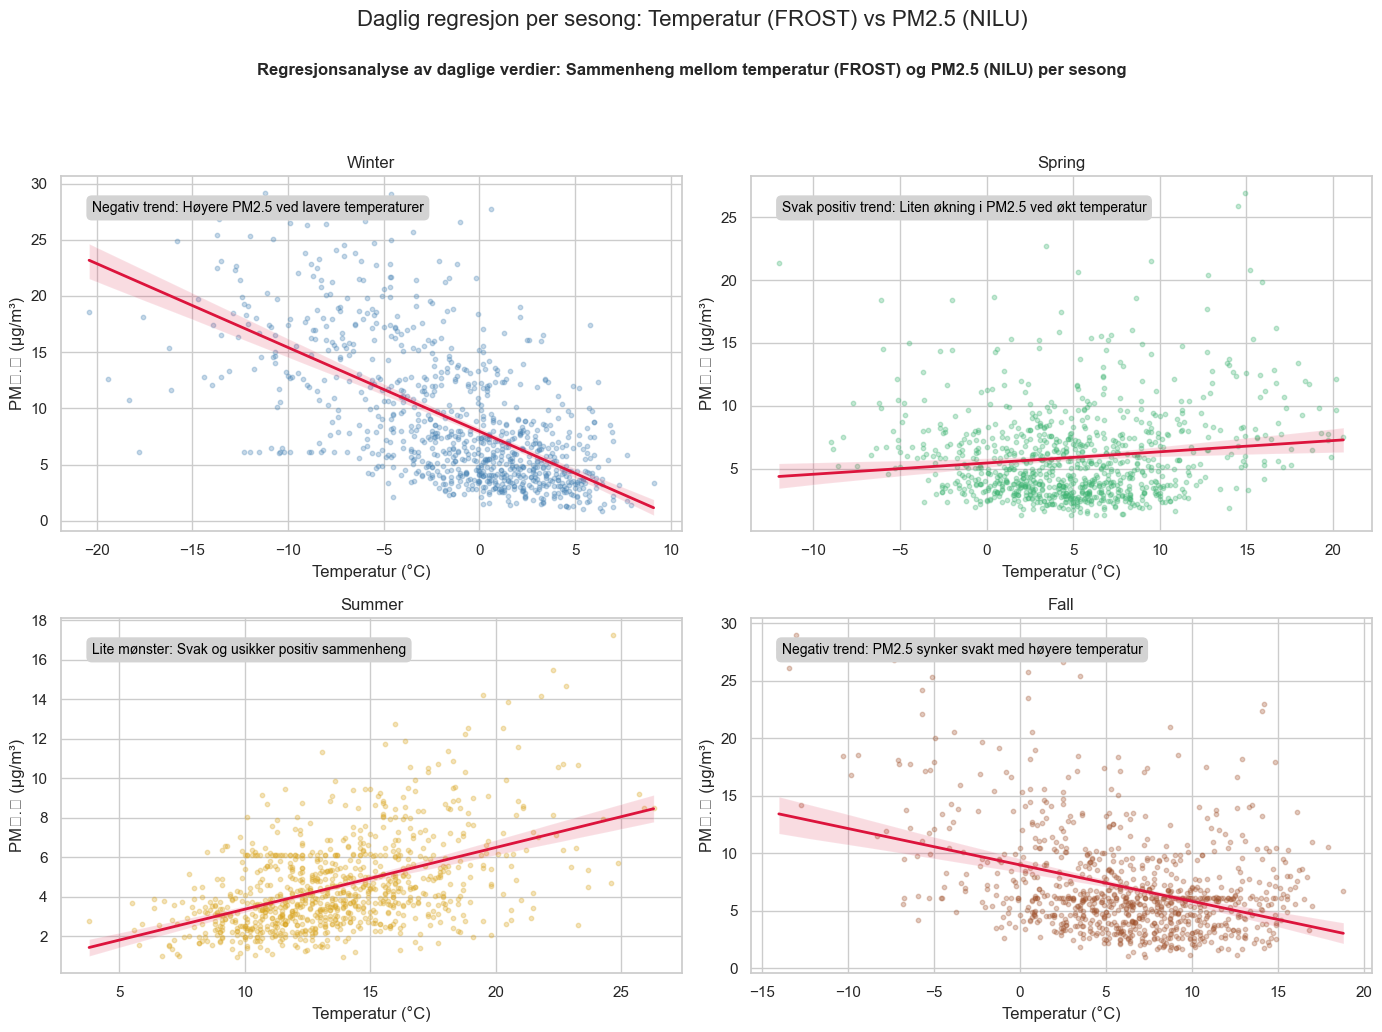

In [23]:
from data_visualizations.frost_vs_nilu_visualization.Temperature_vs_NO2 import plot_temperature_vs_pm25
plot_temperature_vs_pm25(
    "../data/clean/cleaned_data_nilu.json",
    "../data/clean/frost.db"
)

### Sammenheng mellom NO₂ og PM10-nivåer

Denne visualiseringen utforsker hvordan NO₂ og PM10 nivåer henger sammen. Dette er nyttig for å forstå om høye nivåer av én type forurensning vanligvis opptrer samtidig med høye nivåer av en annen type.


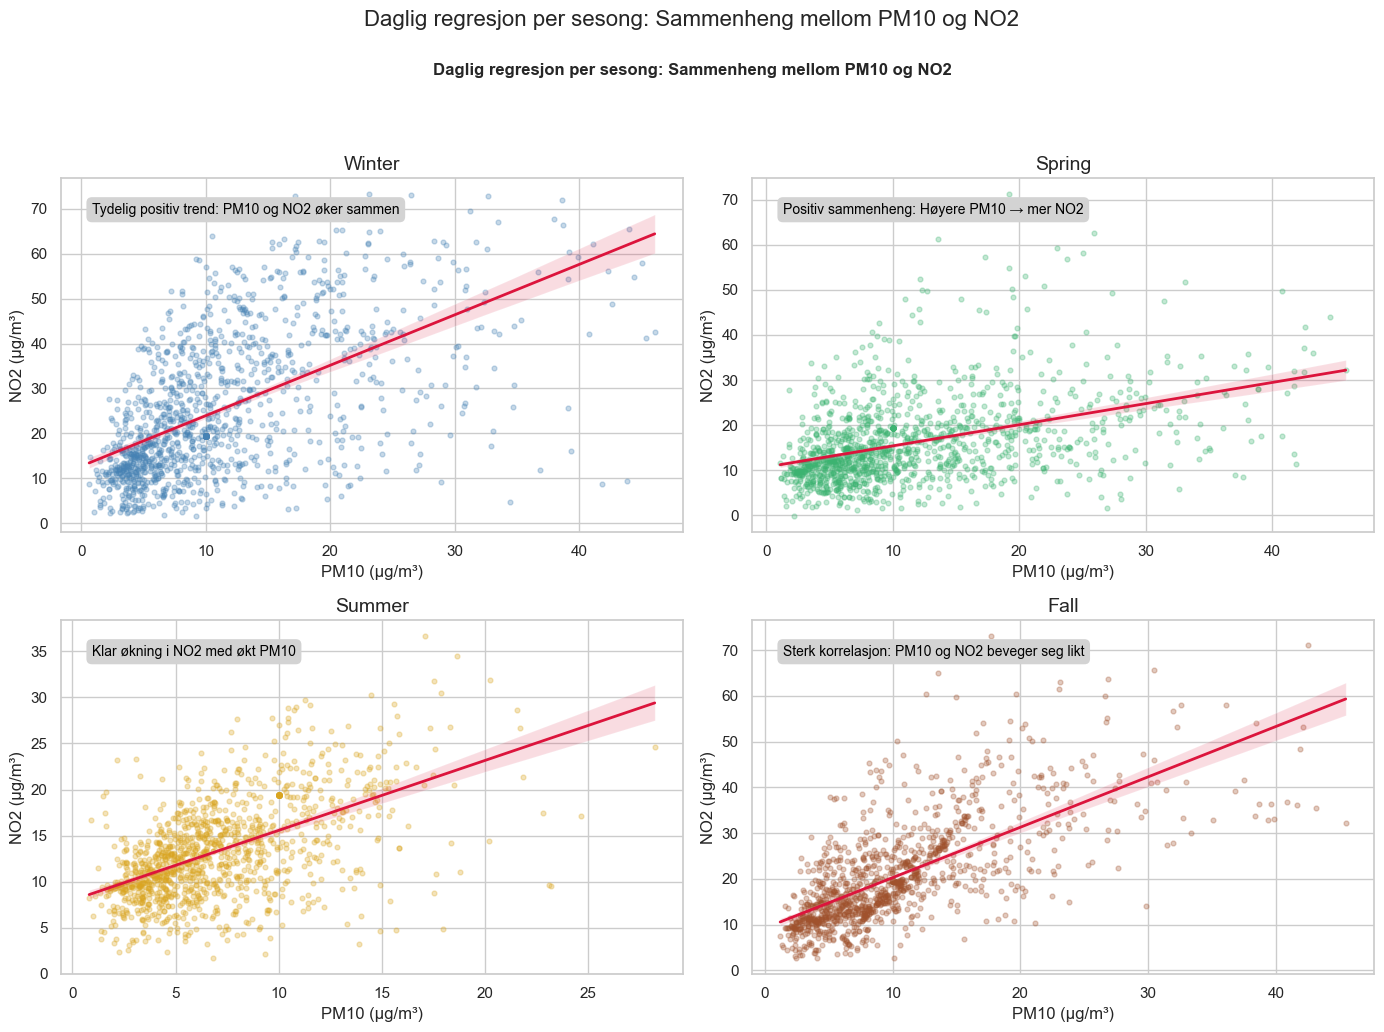

In [25]:
from data_visualizations.nilu_visualization.NO2_vs_PM10 import vis_pm10_vs_no2_per_sesong
vis_pm10_vs_no2_per_sesong("../data/clean/cleaned_data_nilu.json")